# Netflix movie recommendation engine
Kaggle competition link: https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data 

### Given data:<br>
There are 4 txt files (combined_data_(1,2,3,4).txt) given.<br>
Each file consists of movie ID followed by colon and then list of Customer ID, Rating, Date on each of next line.<br>
~ MovieIDs range from 1 to 17770 sequentially. <br>
~ CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users. <br>
~ Ratings are on a five star (integral) scale from 1 to 5. <br>
~ Dates have the format YYYY-MM-DD.<br><br>
The txt format is like this:
<br><br>
MovieID1:<br>
CustomerID11,Rating11,Date11<br>
CustomerID12,Rating12,Date12<br>
...<br>
MovieID2:<br>
CustomerID21,Rating21,Date21<br>
CustomerID22,Rating22,Date22<br>
<br>
Another file is provided in which movie information is given "movie_titles.txt" is in the following format:<br>

MovieID,YearOfRelease,Title

~ MovieID do not correspond to actual Netflix movie ids or IMDB movie ids. <br>
~ YearOfRelease can range from 1890 to 2005 and may correspond to the release of corresponding DVD, not necessarily its theaterical release. <br>
~ Title is the Netflix movie title and may not correspond to titles used on other sites. Titles are in English.<br>

<br>

### Objectives:
1. Predict the rating that a user would give to a movie that he ahs not yet rated.
2. Minimize the difference between predicted and actual rating (RMSE and MAPE)

### My strategy to follow to solve this:

1. Preprocessing and EDA - Here we will bring the data in required format which will be easy to manipulate or analyze using dataframes. After that we will perform Exploratory Data Analysis on whole data. 
2. Splitting data - After EDA, we will split the data into train and test so that we can evaluate our future recommender model.
3. Feature Engineering - Here we will try to find/derive the features which will be useful in predicting the ratings. Few of the features I can think of now is average rating given by the user, average rating received for movie, ratings from top 10 similar users, ratings for top 10 similar movies etc. Here we will be using basic statistics, collaborative filtering methods or some advanced techniques to find the features.
4. Model building - Once we find the features, we will try to build models on it. We will be using some standard / most popular models for recommendation systems or may stack few depending on the results we will get. 
5. Hyperparameter tuning - Based on the model we will build, we may need to do some hyperparameter tuning. 

### 1. Preprocessing

In [67]:
# Initial imports
from datetime import datetime # To compute time taken wherever necessary
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

#### Convert the data to table format like movieID, userID, rating <br> After that, merge data from all 4 .txt files to 1 csv

In [14]:
# Define the input folder, input files and transformed folder
input_folder = 'F:/09 - Machine Learning Case Studies/01 - Netflix Movies Recommendation/Input Data'
transformed_folder = 'F:/09 - Machine Learning Case Studies/01 - Netflix Movies Recommendation/Transformed Data'
input_files = [input_folder+'/combined_data_1.txt', input_folder+'/combined_data_2.txt', input_folder+'/combined_data_3.txt', input_folder+'/combined_data_4.txt']

start = datetime.now()
if not os.path.isfile(transformed_folder+'/input_data.csv'):
    transformed_data_file = open(transformed_folder+'/input_data.csv', mode='w')
    
    for current_file in input_files:
        print('Reading data from {}'.format(current_file))
        with open(current_file) as file_content:
            for each_line in file_content:
                each_line = each_line.strip()
                if each_line.endswith(':'): # This is line on which movie_id is present
                    movie_id = each_line.replace(':', '')
                else: # Rest of the data lines where UserID, Rating, Date are present
                    record = [word for word in each_line.split(',')]
                    record.insert(0, movie_id)
                    transformed_data_file.write(','.join(record))
                    transformed_data_file.write('\n')
        print('Done.\n')
    transformed_data_file.close()
print('\nTime taken for transformation: ', datetime.now()-start)

Reading data from F:/09 - Machine Learning Case Studies/01 - Netflix Movies Recommendation/Input Data/combined_data_1.txt
Done.

Reading data from F:/09 - Machine Learning Case Studies/01 - Netflix Movies Recommendation/Input Data/combined_data_2.txt
Done.

Reading data from F:/09 - Machine Learning Case Studies/01 - Netflix Movies Recommendation/Input Data/combined_data_3.txt
Done.

Reading data from F:/09 - Machine Learning Case Studies/01 - Netflix Movies Recommendation/Input Data/combined_data_4.txt
Done.


Time taken for transformation:  0:04:29.441330


In [20]:
# Load the transformed input data to DataFrame
start = datetime.now()
print('Loading the transformed .csv into DataFrame')
input_data_df = pd.read_csv(transformed_folder+'/input_data.csv', sep=',', names=['movie','user','rating','date'])
input_data_df.date = pd.to_datetime(input_data_df.date) # Change datatype to datetime
print('Done.\n')
print('*'*50)
print('Time taken for the task: ', datetime.now()-start)

Loading the transformed .csv into DataFrame
Done.

**************************************************
Time taken for the task:  0:01:06.235585


In [17]:
input_data_df.head()

,movie,user,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


In [21]:
# Sort the dataframe based on date ascendingly
start = datetime.now()
print('Sorting the DataFrame by date in ascending order')
input_data_df.sort_values(by='date', inplace=True)
print('Done.\n')
print('*'*50)
print('Time taken for the task: ', datetime.now()-start)

Sorting the DataFrame by date in ascending order
Done.

**************************************************
Time taken for the task:  0:00:38.889256


In [23]:
input_data_df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


### 2. EDA

#### Check for NaN or null values

In [29]:
print('Total NaN values: {}'.format(sum(input_data_df.isnull().any())))

Total NaN values: 0


#### Check for duplicates

In [30]:
print('Total duplicate values: \n{}'.format(input_data_df.duplicated().value_counts()))

Total duplicate values: 
False    100480507
dtype: int64


#### Basic stats

In [34]:
print('Basic stats')
print('Total movies: {}'.format(len(input_data_df['movie'].unique())))
print('Total users: {}'.format(len(input_data_df['user'].unique())))
print('Total ratings: {}'.format(len(input_data_df['rating'])))

Basic stats
Total movies: 17770
Total users: 480189
Total ratings: 100480507


In [36]:
print('Average rating by all users: {}'.format(input_data_df['rating'].mean()))

Average rating by all users: 3.604289964420661


In [38]:
print('Average number of ratings by each user: {}'.format( len(input_data_df['rating'])/len(input_data_df['user'].unique())))
print('Average number of ratings for each movie: {}'.format( len(input_data_df['rating'])/len(input_data_df['movie'].unique())))

Average number of ratings by each user: 209.25199660966828
Average number of ratings for each movie: 5654.502363534046


The above stat shows that on average 1 user has rated 209 movies.

#### Analysis on 'Date'

In [64]:
def number_to_units(number):
    if number > 999999999:
        return str(round(number/10**9,1))+" B"
    elif number > 999999:
        return str(round(number/10**6,1))+" M"
    elif number > 999:
        return str(round(number/10**3,1))+" K"
    else:
        return str(number)

In [48]:
# Add additional columns for Year, Month, Day of Week
input_data_df['year'] = input_data_df['date'].dt.year
input_data_df['month'] = input_data_df['date'].dt.month
input_data_df['day_of_week'] = input_data_df['date'].dt.day_of_week
print('year, month and day_of_week columns are created.')

year, month and day_of_week columns are created.


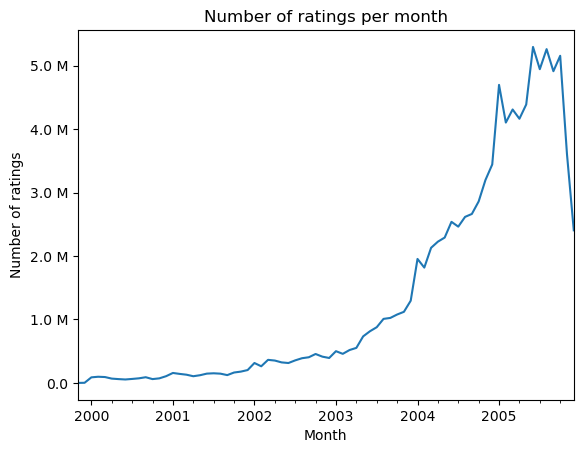

In [81]:
# Plot a trend line
ax = input_data_df.resample('m', on='date')['rating'].count().plot()

# Set plot title and axis labels
ax.set_title('Number of ratings per month')
ax.set_xlabel('Month')
ax.set_ylabel('Number of ratings')

# Set y axis labels
ax.set_yticklabels([number_to_units(x) for x in ax.get_yticks()])

# Show plot
plt.show()

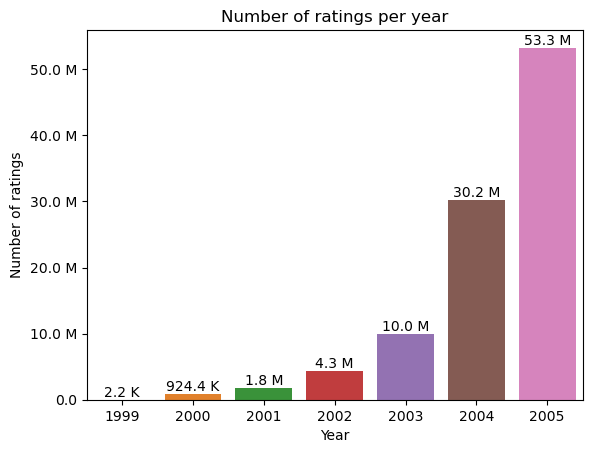

In [72]:
# Plot number of ratings per year

# Plot using sns countplot
ax = sns.countplot(data=input_data_df, x='year')

# Set plot title & axis labels
plt.title('Number of ratings per year')
ax.set_ylabel('Number of ratings')
ax.set_xlabel('Year')

# Set y axis labels
ax.set_yticklabels([number_to_units(x) for x in ax.get_yticks()])

# Set bar labels
abs_labels = [number_to_units(x) for x in input_data_df['year'].value_counts().sort_index()]
ax.bar_label(container=ax.containers[0], labels = abs_labels)

# Show plot
plt.show()

Conclusion:
1. The number of ratings have been increased a lot in recent years

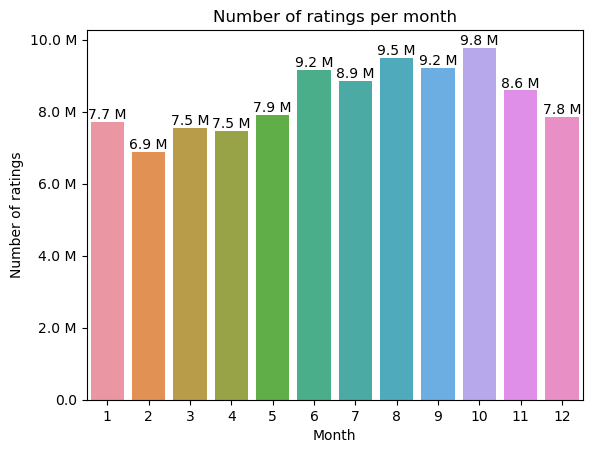

In [78]:
# Plot number of ratings per month

# Plot using sns countplot
ax = sns.countplot(data=input_data_df, x='month')

# Set plot title & axis labels
plt.title('Number of ratings per month')
ax.set_ylabel('Number of ratings')
ax.set_xlabel('Month')

# Set y axis labels
ax.set_yticklabels([number_to_units(x) for x in ax.get_yticks()])

# Set bar labels
abs_labels = [number_to_units(x) for x in input_data_df['month'].value_counts().sort_index()]
ax.bar_label(container=ax.containers[0], labels = abs_labels)

# Show plot
plt.show()

Conclusion:
1. June to October months (6 to 10) seems to get more number of ratings than rest of the year

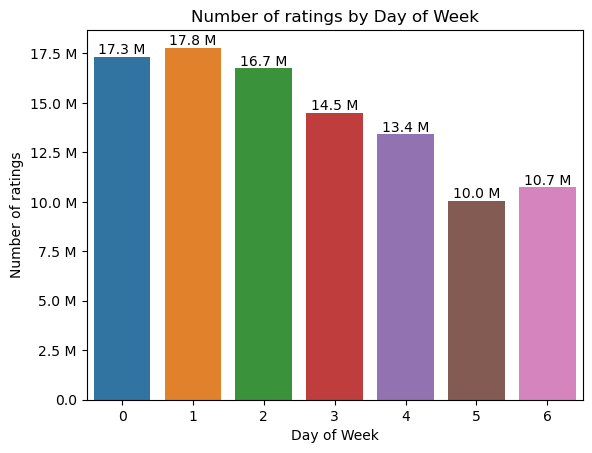

In [77]:
# Plot number of ratings by day of week

# Plot using sns countplot
ax = sns.countplot(data=input_data_df, x='day_of_week')

# Set plot title & axis labels
plt.title('Number of ratings by Day of Week')
ax.set_ylabel('Number of ratings')
ax.set_xlabel('Day of Week')

# Set y axis labels
ax.set_yticklabels([number_to_units(x) for x in ax.get_yticks()])

# Set bar labels
abs_labels = [number_to_units(x) for x in input_data_df['day_of_week'].value_counts().sort_index()]
ax.bar_label(container=ax.containers[0], labels = abs_labels)

# Show plot
plt.show()

Conclusion:
1. There has been lesser ratings given on Weekends (Saturday - 5  & Sundays - 6) than Weekdays

In [98]:
# Delete the columns 'year', 'month', 'day_of_week', and 'date' since we no longer need them
input_data_df.drop(columns=['year', 'month', 'day_of_week', 'date'], axis=1, inplace=True)

In [101]:
input_data_df.head()

,movie,user,rating
56431994,10341,510180,4
9056171,1798,510180,5
58698779,10774,510180,3
48101611,8651,510180,2
81893208,14660,510180,2


#### Analysis on 'user'

In [83]:
# Total number of ratings given by each user
total_ratings_per_user = input_data_df.groupby(by='user')['rating'].count().sort_values(ascending=False)

In [84]:
total_ratings_per_user.head()

user
305344     17653
387418     17436
2439493    16565
1664010    15813
2118461    14831
Name: rating, dtype: int64

It seems like there are many users who have given more than 10,000 ratings which usually is not possible. Lets look at the distribution of total ratings per user

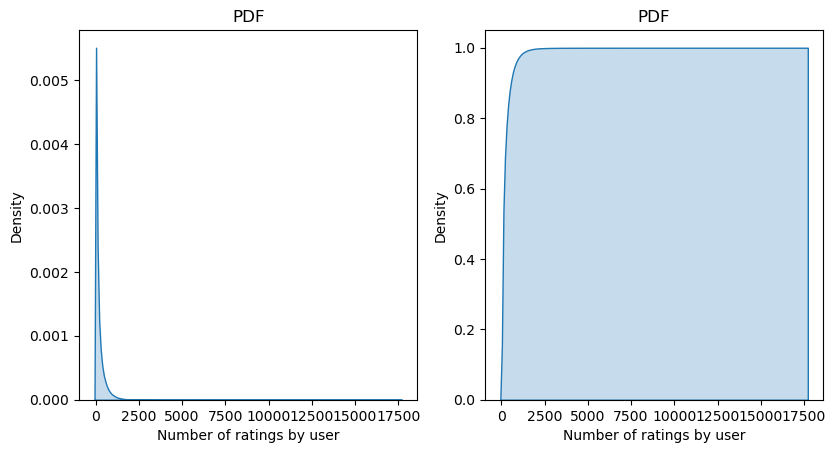

In [85]:
# Plot PDF & CDF for this
fig = plt.figure(figsize=plt.figaspect(0.5))

# PDF
ax1 = plt.subplot(121)
sns.kdeplot(total_ratings_per_user, shade=True, ax=ax1)
plt.xlabel("Number of ratings by user")
plt.title("PDF")

# CDF
ax1 = plt.subplot(122)
sns.kdeplot(total_ratings_per_user, shade=True, cumulative=True, ax=ax1)
plt.xlabel("Number of ratings by user")
plt.title("PDF")

plt.show()

In [86]:
total_ratings_per_user.describe()

count    480189.000000
mean        209.251997
std         302.339155
min           1.000000
25%          39.000000
50%          96.000000
75%         259.000000
max       17653.000000
Name: rating, dtype: float64

Lets look at quantiles with 5% interval

In [89]:
total_ratings_per_user.quantile(np.arange(0, 1.01, 0.05))

0.00        1.0
0.05       12.0
0.10       19.0
0.15       25.0
0.20       31.0
0.25       39.0
0.30       46.0
0.35       55.0
0.40       66.0
0.45       80.0
0.50       96.0
0.55      117.0
0.60      142.0
0.65      173.0
0.70      211.0
0.75      259.0
0.80      322.0
0.85      410.0
0.90      541.0
0.95      779.0
1.00    17653.0
Name: rating, dtype: float64

We can see that over 95% of the users have not given more than 780 ratings

#### Analysis on 'movie'

In [90]:
total_ratings_per_movie = input_data_df.groupby(by='movie')['rating'].count().sort_values(ascending=False)

In [93]:
total_ratings_per_movie.head()

movie
5317     232944
15124    216596
14313    200832
15205    196397
1905     193941
Name: rating, dtype: int64

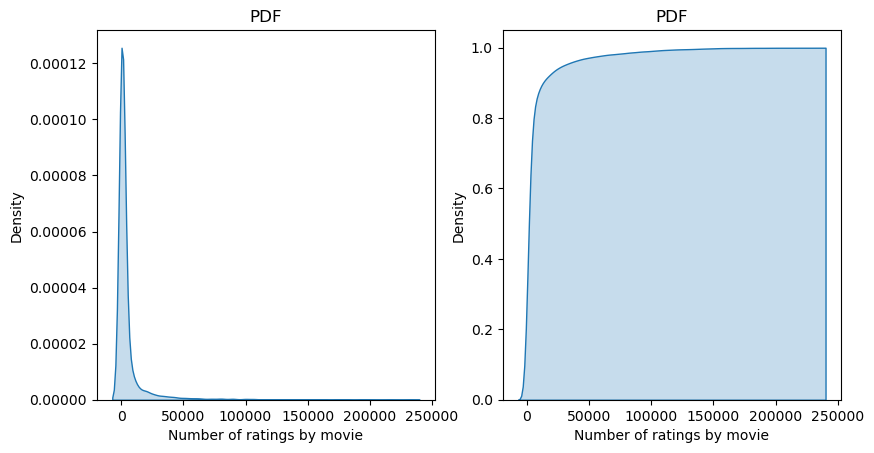

In [94]:
# Plot PDF & CDF for this
fig = plt.figure(figsize=plt.figaspect(0.5))

# PDF
ax1 = plt.subplot(121)
sns.kdeplot(total_ratings_per_movie, shade=True, ax=ax1)
plt.xlabel("Number of ratings by movie")
plt.title("PDF")

# CDF
ax1 = plt.subplot(122)
sns.kdeplot(total_ratings_per_movie, shade=True, cumulative=True, ax=ax1)
plt.xlabel("Number of ratings by movie")
plt.title("PDF")

plt.show()

In [95]:
total_ratings_per_movie.describe()

count     17770.000000
mean       5654.502364
std       16909.673269
min           3.000000
25%         192.000000
50%         561.000000
75%        2667.750000
max      232944.000000
Name: rating, dtype: float64

Its obvious that popular movies will receive far more ratings than unpopular movies

In [96]:
total_ratings_per_movie.quantile(np.arange(0, 1.01, 0.05))

0.00         3.00
0.05        98.00
0.10       117.00
0.15       137.00
0.20       161.00
0.25       192.00
0.30       228.00
0.35       281.00
0.40       349.60
0.45       439.00
0.50       561.00
0.55       754.00
0.60      1006.40
0.65      1360.00
0.70      1948.30
0.75      2667.75
0.80      4040.20
0.85      6638.85
0.90     12303.80
0.95     29199.60
1.00    232944.00
Name: rating, dtype: float64

Only 5% of the movies have received more than 30,000 ratings

### Split the data into Train & Test

Next, we need to transpose the data into sparse matrix so that we can create user-based and/or item-based matrix. For this, we need all users as rows and all movies as columns. The value in each cell will be the rating for that particular movie by the particular user. <br>
Before this, we will split the data into train & test in the ratio 80:20. This split will be based on time since our dataframe is already sorted based on 'date'. Meaning, based on date, first 80% of the data will be train data while the last 20% data will be test data.

In [102]:
start = datetime.now()
# Train
print('Splitting input data into train & test in 80:20 ratio...\n')
if not os.path.isfile(transformed_folder+'/train.csv'):
    input_data_df.iloc[:int(input_data_df.shape[0]*0.80)].to_csv(transformed_folder+'/train.csv', index=False)
    print(transformed_folder+'/train.csv is created.\n')
    print('Time taken: {}'.format(datetime.now() - start))


# Test 
if not os.path.isfile(transformed_folder+'/test.csv'):
    input_data_df.iloc[int(input_data_df.shape[0]*0.80):].to_csv(transformed_folder+'/test.csv', index=False)
    print(transformed_folder+'/test.csv is created.\n')
    print('Time taken: {}'.format(datetime.now() - start))

Splitting input data into train & test in 80:20 ratio...

F:/09 - Machine Learning Case Studies/01 - Netflix Movies Recommendation/Transformed Data/train.csv is created.

Time taken: 0:01:40.889652
F:/09 - Machine Learning Case Studies/01 - Netflix Movies Recommendation/Transformed Data/test.csv is created.

Time taken: 0:02:05.826547


In [103]:
# Lets get basic stats for newly splitted data
train_df = pd.read_csv(transformed_folder+'/train.csv')
test_df = pd.read_csv(transformed_folder+'/test.csv')

In [104]:
print('Shape of train data: {}'.format(train_df.shape))
print('Shape of test data: {}'.format(test_df.shape))

Shape of train data: (80384405, 3)
Shape of test data: (20096102, 3)


In [116]:
print('Basic stats on train')
print('Total movies: {}'.format(len(train_df['movie'].unique())))
print('Total users: {}'.format(len(train_df['user'].unique())))
print('Total ratings: {}'.format(len(train_df['rating'])))

Basic stats on train
Total movies: 17424
Total users: 405041
Total ratings: 80384405


In [117]:
print('Basic stats on test')
print('Total movies: {}'.format(len(test_df['movie'].unique())))
print('Total users: {}'.format(len(test_df['user'].unique())))
print('Total ratings: {}'.format(len(test_df['rating'])))

Basic stats on test
Total movies: 17757
Total users: 349312
Total ratings: 20096102


Just as curiosity, lets check memory usage by our main large DataFrames

In [105]:
input_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100480507 entries, 56431994 to 25464092
Data columns (total 3 columns):
 #   Column  Dtype
---  ------  -----
 0   movie   int64
 1   user    int64
 2   rating  int64
dtypes: int64(3)
memory usage: 3.0 GB


In [106]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80384405 entries, 0 to 80384404
Data columns (total 3 columns):
 #   Column  Dtype
---  ------  -----
 0   movie   int64
 1   user    int64
 2   rating  int64
dtypes: int64(3)
memory usage: 1.8 GB


In [107]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20096102 entries, 0 to 20096101
Data columns (total 3 columns):
 #   Column  Dtype
---  ------  -----
 0   movie   int64
 1   user    int64
 2   rating  int64
dtypes: int64(3)
memory usage: 460.0 MB


### Convert into Sparse matrix
To compute similarity matrix, we need data in a special format (i.e. users as rows and movies as columns). If we store this data as DataFrame/CSV, it will consume a lot of space. And we know that most of the cells in this matrix are going to be zero. So, we will store this matrix as sparse (CSR) matrix which helps us to store this data in compressed format.


In [108]:
# Some imports
from scipy import sparse
from scipy.sparse import csr_matrix

#### Create sparse matrix from train

In [109]:
start = datetime.now()

# Check if already exists, else create
if os.path.isfile(transformed_folder+'/train_sparse_matrix.npz'):
    print('Sparse matrix for train already exists, getting it from disk...')
    train_sparse_matrix = sparse.load_npz(transformed_folder+'/train_sparse_matrix.npz')
    print('Done!')
    print('Time taken: {}'.format(datetime.now() - start))
else:
    print('Creating sparse matrix from train...')
    
    # csr_matrix( (data, (rows, columns)), shape )
    train_sparse_matrix = csr_matrix( (train_df.rating.values, (train_df.user.values, train_df.movie.values)), )
    
    # save to disk
    print('Saving to {}'.format(transformed_folder+'/train_sparse_matrix.npz'))
    sparse.save_npz(transformed_folder+'/train_sparse_matrix.npz', train_sparse_matrix)
    print('Done!')
    print('Time taken: {}'.format(datetime.now() - start))

Sparse matrix for train already exists, getting it from disk...
Done!
Time taken: 0:00:02.520345


In [112]:
rows, cols = train_sparse_matrix.shape
non_zeros = train_sparse_matrix.count_nonzero()

print('Sparsity of train_sparse_matrix: {}'.format(1 - (non_zeros/(rows*cols))))

Sparsity of train_sparse_matrix: 0.998292709259195


#### Create sparse matrix from test

In [113]:
start = datetime.now()

if os.path.isfile(transformed_folder+'/test_sparse_matrix.npz'):
    print('Sparse matrix for test already exists, getting it from disk...')
    test_sparse_matrix = sparse.load_npz(transformed_folder+'/test_sparse_matrix.npz')
    print('Done!')
    print('Time taken: {}'.format(datetime.now() - start))
else:
    print('Creating sparse matrix from test...')
    test_sparse_matrix = csr_matrix( (test_df.rating.values, (test_df.user.values, test_df.movie.values)), )
    
    # save to disk
    print('Saving to {}'.format(transformed_folder+'/test_sparse_matrix.npz'))
    sparse.save_npz(transformed_folder+'/test_sparse_matrix.npz', test_sparse_matrix)
    print('Done!')
    print('Time taken: {}',format(datetime.now() - start))
    

Sparse matrix for test already exists, getting it from disk...
Done!
Time taken: 0:00:00.646131


In [114]:
rows, cols = test_sparse_matrix.shape
non_zeros = test_sparse_matrix.count_nonzero()

print('Sparsity of train_sparse_matrix: {}'.format(1 - (non_zeros/(rows*cols))))

Sparsity of train_sparse_matrix: 0.9995731772988694
